In [260]:
import pandas as pd
import statsmodels.api as sm

import matplotlib as plt
import seaborn as sns

In [261]:
data_dir = "../../preprocessed/" 
features_dir = data_dir + "district_features/regression/"
# labels_dir = data_dir + "regression_labels/" 

In [278]:
label_columns = ["hType_mix", "num_intersect", "bld_avg_age", "emp_rat_num",\
				"LUM5_single",	"RNR_nres", "mdist_smallparks", "nig_rat_daily",\
				"nig_rat_daily3", "mdist_nres_daily", "num_community_places", \
				"num_community_places_poi", "avg_block_area", "sphi", \
				"enterprises_empl_size", "pop_rat_num",  \
				"emp_rat_pop", "den_nres_daily",\
				"mdist_parks", "den_nres_non-daily", "mdist_railways",\
				"mdist_highways", "mdist_water", "activity_density"]

In [279]:
PCA_components = 8

LABELING_METHOD = "threshold"
AVERAGING_METHOD = "average"

features_columns = ["PCA"+str(i) for i in range(PCA_components)]
geo_columns = ["centroid_x", "centroid_y"]

USE_GEO = "ONLY_GEO"
if USE_GEO == "ALSO_GEO" and AVERAGING_METHOD != "kaist":
    features_columns = features_columns + ["centroid_x", "centroid_y"]
elif USE_GEO == "ONLY_GEO":
    features_columns = geo_columns
    



    
JJ_features_columns = ["label_" + c for c in label_columns if c != "activity_density"]
        

network_type = "vgg16_4096"



In [280]:
def get_normalized_labels_features():
    if network_type == "vgg19":
        df = pd.read_csv(features_dir + "Italy_6_cities_vgg19_pca"+str(PCA_components)+"_linear_fc_thirdlast_layer_labels_features.csv")
    elif network_type == "resnet50":
        df = pd.read_csv(features_dir + "Italy_6_cities_resnet_pca"+str(PCA_components)+"_second_last_layer_labels_features.csv")
    elif network_type == "vgg16_4096":
        df = pd.read_csv(features_dir + "Italy_6_cities_resnet_pca" + str(PCA_components) + "_vgg16_4096_"\
                         + LABELING_METHOD + "_" + AVERAGING_METHOD + "_labels_features.csv")

    df["label_district"] = df["label_district"].astype(str)
    df["city_district"] = df.\
        apply(lambda x: x.city + "_" + x.label_district, axis = 1)
    try:
        del df['index']
    except:
        pass
    return df

In [281]:
data = get_normalized_labels_features()

In [282]:
data.head()

,label_district,label_hType_mix,label_num_intersect,label_bld_avg_age,label_emp_rat_num,label_LUM5_single,label_RNR_nres,label_mdist_smallparks,label_nig_rat_daily,label_nig_rat_daily3,...,label_mdist_parks,label_den_nres_non-daily,label_mdist_railways,label_mdist_highways,label_mdist_water,label_activity_density,centroid_x,centroid_y,city,city_district
0,1,0.573700,0.916695,0.751124,1.000000,0.537578,0.642843,0.287677,0.462518,0.984166,...,0.388441,1.000000,0.303275,0.062985,0.352610,0.985182,0.590576,0.422609,milano,milano_1
1,2,0.107239,0.827186,0.704957,0.881167,0.721184,0.960190,0.283043,0.574682,1.000000,...,0.723512,0.878995,0.356367,0.001150,0.203797,1.000000,0.590576,0.526957,milano,milano_2
2,3,0.353503,0.806998,0.670139,0.781434,0.567699,0.880010,0.479659,1.000000,0.925168,...,0.322766,0.616451,0.537791,0.000000,0.265443,0.864860,0.604712,0.626087,milano,milano_3
3,4,0.739311,0.537262,0.553459,0.637389,0.720690,0.744286,0.505823,0.519780,0.327350,...,0.154357,0.405842,0.626548,0.067999,0.251033,0.660278,0.557592,0.704348,milano,milano_4
4,5,0.301963,0.824333,0.755611,0.878579,0.215426,0.674176,0.180298,0.450705,0.476909,...,0.417627,0.639340,0.579227,0.027418,0.387328,0.839758,0.698953,0.652174,milano,milano_5


In [283]:
if AVERAGING_METHOD == "kaist":
    features_columns = [c for c in data.columns if "f_" in c]

In [284]:
len(features_columns)

2

In [285]:
len(data)

370

In [286]:
def predict_SAT_model(label="label_activity_density"):
    
    ss = data[["city_district", label] + features_columns]
    ss = ss.dropna()
    
    target = ss[["city_district", label]]
    features = ss[features_columns]
    
    X = features.values
    y = target[label].values
    
    X = sm.add_constant(X)  
    model = sm.OLS(y,X)
    
    results = model.fit()
    
    print ("LABEL ", label)
    print_model = results.summary()
    print (print_model)
    
    return results.rsquared_adj

In [287]:
predict_SAT_model()

LABEL  label_activity_density
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.111
Date:                Sat, 04 Apr 2020   Prob (F-statistic):              0.330
Time:                        12:54:14   Log-Likelihood:                 3.3470
No. Observations:                 370   AIC:                           -0.6939
Df Residuals:                     367   BIC:                             11.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5217 

0.0006027003817181686

In [199]:
def predict_Pop_Dens_model(label="label_activity_density"):
    
    ss = data[["city_district", label] + ["label_pop_rat_num"]]
    ss = ss.dropna()
    
    target = ss[["city_district", label]]
    features = ss[['label_pop_rat_num']]
    
    X = features.values
    y = target[label].values
    
    X = sm.add_constant(X)  
    model = sm.OLS(y,X)
    
    results = model.fit()
    
    print ("LABEL ", label)
    print_model = results.summary()
    print (print_model)
    
    return results.rsquared_adj

In [200]:
predict_Pop_Dens_model()

LABEL  label_activity_density
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     229.0
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           1.43e-40
Time:                        12:45:08   Log-Likelihood:                 91.751
No. Observations:                 370   AIC:                            -179.5
Df Residuals:                     368   BIC:                            -171.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1498 

0.38194846785674175

In [201]:
def predict_JJ_model(label="label_activity_density"):
    
    ss = data[["city_district", label] + JJ_features_columns]
    ss = ss.dropna()
    
    target = ss[["city_district", label]]
    features = ss[JJ_features_columns]
    
    X = features.values
    y = target[label].values
    
    X = sm.add_constant(X)  
    model = sm.OLS(y,X)
    
    results = model.fit()
    
    print ("LABEL ", label)
    print_model = results.summary()
    print (print_model)
    
    return results.rsquared_adj

In [202]:
predict_JJ_model()

LABEL  label_activity_density
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     77.20
Date:                Sat, 04 Apr 2020   Prob (F-statistic):          3.28e-121
Time:                        12:45:11   Log-Likelihood:                 337.72
No. Observations:                 370   AIC:                            -627.4
Df Residuals:                     346   BIC:                            -533.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3034 

0.8260667115496091

In [203]:
def predict_Pop_Dens_SAT_model(label="label_activity_density"):
    
    ss = data[["city_district", label] + ["label_pop_rat_num"] + features_columns]
    ss = ss.dropna()
    
    target = ss[["city_district", label]]
    features = ss[features_columns + ['label_pop_rat_num']]
    
    X = features.values
    y = target[label].values
    
    X = sm.add_constant(X)  
    model = sm.OLS(y,X)
    
    results = model.fit()
    
    print ("LABEL ", label)
    print_model = results.summary()
    print (print_model)
    
    return results.rsquared_adj

In [204]:
predict_Pop_Dens_SAT_model()

LABEL  label_activity_density
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     12.72
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           2.20e-42
Time:                        12:45:15   Log-Likelihood:                 155.61
No. Observations:                 370   AIC:                            -241.2
Df Residuals:                     335   BIC:                            -104.2
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2060 

0.5192525122493314

In [205]:
def predict_JJ_SAT_model(label="label_activity_density"):
    
    ss = data[["city_district", label] + JJ_features_columns + features_columns]
    ss = ss.dropna()
    
    target = ss[["city_district", label]]
    features = ss[JJ_features_columns + features_columns]
    
    X = features.values
    y = target[label].values
    
    X = sm.add_constant(X)  
    model = sm.OLS(y,X)
    
    results = model.fit()
    
    print ("LABEL ", label)
    print_model = results.summary()
    print (print_model)
    
    return results.rsquared_adj

In [206]:
predict_JJ_SAT_model()

LABEL  label_activity_density
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     37.27
Date:                Sat, 04 Apr 2020   Prob (F-statistic):          1.35e-108
Time:                        12:45:19   Log-Likelihood:                 379.07
No. Observations:                 370   AIC:                            -644.1
Df Residuals:                     313   BIC:                            -421.1
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0357 

0.8462446902535475

In [207]:
plot_me = {}
plot_me["Pop Dens"] = \
    {"Baseline": predict_Pop_Dens_model(), "Baseline + SAT":predict_Pop_Dens_SAT_model()}

plot_me["JJ variables"] = \
    {"Baseline": predict_JJ_model(), "Baseline + SAT":predict_JJ_SAT_model()}

LABEL  label_activity_density
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     229.0
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           1.43e-40
Time:                        12:45:22   Log-Likelihood:                 91.751
No. Observations:                 370   AIC:                            -179.5
Df Residuals:                     368   BIC:                            -171.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1498 

In [208]:
df = pd.DataFrame(plot_me)
df.T

,Baseline,Baseline + SAT
Pop Dens,0.381948,0.519253
JJ variables,0.826067,0.846245


In [209]:
def plot_res(df):
    
    fig, ax = plt.pyplot.subplots(figsize=(7,5))
    sns.set_style("white")
    sns.set_context("paper")


    df = df.sort_index(ascending=False)


    colors = ["lightskyblue", "cadetblue"]


    df.plot.bar(ax=ax, edgecolor = "white", color=colors, alpha=0.777, capsize=3)


    ax.set_xlabel('')

    ax.set_ylim(0,.97)

    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_yticklabels() + ax.get_xticklabels()):
                item.set_fontsize(18)
                item.set_weight('bold')
                
#     for p in ax.patches:
#         ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    x_offset = -0.08
    y_offset = 0.015
    for p in ax.patches:
        b = p.get_bbox()
        val = "{:.2f}".format(b.y1 + b.y0).lstrip('0')        
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=15, fontweight="bold")
    
#     plt.axhline(y=0.5, ls='--', color='red')

    labels = [tick.get_text() for tick in ax.get_yticklabels()]

    l = plt.pyplot.legend(bbox_to_anchor=(1.0, 1.0), prop={'size':16, 'weight':'bold'})
#     l.draw_frame(False)

    plt.pyplot.axvline(x=4.5, ls='--', color='gray')


    plt.pyplot.tight_layout()

    plt.pyplot.savefig('../../results/districts/regression/fig/only_LR_JJ_PopDens_SAT_'+AVERAGING_METHOD+'.png', dpi=100)

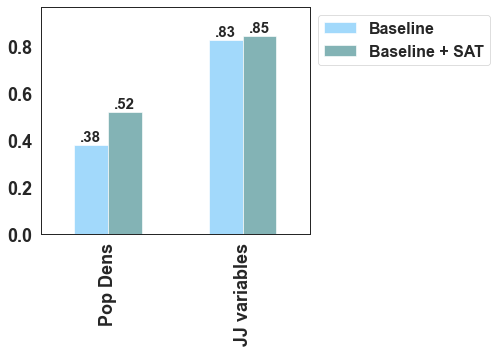

In [181]:
plot_res(df.T)

In [210]:
for col in label_columns:
    label = "label_" + col
    predict_SAT_model(label)

LABEL  label_hType_mix
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     7.107
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           3.50e-23
Time:                        12:45:31   Log-Likelihood:                 86.387
No. Observations:                 370   AIC:                            -104.8
Df Residuals:                     336   BIC:                             28.28
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0033      0.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     4.511
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           3.09e-13
Time:                        12:45:31   Log-Likelihood:                 112.49
No. Observations:                 370   AIC:                            -157.0
Df Residuals:                     336   BIC:                            -23.93
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0740      0.218     -0.340      0.7

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     18.28
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           1.35e-56
Time:                        12:45:31   Log-Likelihood:                 128.13
No. Observations:                 370   AIC:                            -188.3
Df Residuals:                     336   BIC:                            -55.21
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0185      0.209      4.877      0.0